# Data processing and CT/CRF models (building and evaluation)

In [1]:
import pandas as pd
import sys
import csv

#csv.field_size_limit(sys.maxsize)

In [ ]:
!pip install transformers==2.6.0
!pip3 install torch==1.6.0
!pip3 install transformers
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.9/540.9 KB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 69.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d4fa33675f11288b4eb538fe006e65677c20491a127288e3e4ec3845bc425c57
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
#from seqeval.metrics import f1_score
transformers.__version__
torch.__version__
tf.test.gpu_device_name()

2023-01-29 11:20:26.640190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 11:20:27.366307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-29 11:20:27.366363: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-29 11:20:30.232608: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

''

In [3]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
import seaborn as sns
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/NKJP_org.csv',sep= "\t",
                   names = ['word','morf','cat_1','cat_2'], header=None,encoding='utf-8',engine = 'python', quotechar='"', error_bad_lines=False)

Skipping line 401725: field larger than field limit (131072)
Skipping line 725479: '	' expected after '"'
Skipping line 831189: unexpected end of data


In [5]:
data.shape

(773975, 4)

In [6]:
b = []
for i in range(0,len(data.word)):
    if data.cat_1[i] == None and data.cat_2[i] == None:
        b.append('O')
    if data.cat_2[i] != None:
        b.append(data.cat_2[i])
    if data.cat_1[i] != None and data.cat_2[i] == None:
        b.append(data.cat_1[i])
    

In [7]:
data['cat_final']=b

In [9]:
#additional features

In [10]:
g = []
for i in range (0,len(data.word)):
    if str(data['word'][i])[0].isupper():
        g.append(1)
    else:
        g.append(0)
data['is_upper'] = g

In [11]:
#g = []
for i in range (0,len(data.word)):
    if str(data['word'][i])[0] == '\t':
        data['word'][i] = '.'
    else:
        continue
#data['to_skip'] = g

In [12]:

data

word                 morf     cat_1     cat_2 cat_final  \
0       Zatrzasnął     praet:sg:m1:perf      None      None         O   
1            drzwi    subst:pl:acc:n:pt      None      None         O   
2               od        prep:gen:nwok      None      None         O   
3       mieszkania  subst:sg:gen:n:ncol      None      None         O   
4                ,               interp      None      None         O   
...            ...                  ...       ...       ...       ...   
773970     Szalone     adj:sg:acc:n:pos      None      None         O   
773971       życie  subst:sg:acc:n:ncol      None      None         O   
773972     Rudolfa      subst:sg:gen:m1  persName  forename  forename   
773973           .               interp      None      None         O   
773974      mlaska    fin:sg:ter:imperf      None      None         O   

        is_upper  
0              1  
1              0  
2              0  
3              0  
4              0  
...          ...  
773970         1  
773971         0  
773972         1  
773973         0  
773974         0  

[773975 rows x 6 columns]

In [13]:

data[data['morf'] == 'interp']['word'].value_counts()

.      64812
,      42702
-      11616
–       8462
?       5172
)       2509
(       2444
!       1574
;        591
”        359
„        353
—        179
/        115
“         67
…         60
]         48
[         47
'         32
’         28
''        22
--        13
˝         12
«          9
»          9
_          8
’’         5
·          3
±          2
}          2
{          2
&          1
§          1
uuu        1
Name: word, dtype: int64

In [14]:
#let get rid of trash in interp, will leave only "."

In [15]:
data = data.reset_index(drop=True)


In [16]:
g = []
for i in range (0,len(data.word)):
    if str(data['morf'][i]) == 'interp':
        if (str(data['word'][i]) == '.' or str(data['word'][i]) == '!' or str(data['word'][i]) == '?'):
            continue
        else:
            g.append(i)
    else:
        continue

In [17]:
data = data.reset_index(drop=True)
data = data.drop(data.index[g])
data = data.reset_index(drop=True)

In [18]:
data

word                      morf     cat_1     cat_2 cat_final  \
0       Zatrzasnął          praet:sg:m1:perf      None      None         O   
1            drzwi         subst:pl:acc:n:pt      None      None         O   
2               od             prep:gen:nwok      None      None         O   
3       mieszkania       subst:sg:gen:n:ncol      None      None         O   
4              dwa  num:pl:acc:m3:congr:ncol      None      None         O   
...            ...                       ...       ...       ...       ...   
704268     Szalone          adj:sg:acc:n:pos      None      None         O   
704269       życie       subst:sg:acc:n:ncol      None      None         O   
704270     Rudolfa           subst:sg:gen:m1  persName  forename  forename   
704271           .                    interp      None      None         O   
704272      mlaska         fin:sg:ter:imperf      None      None         O   

        is_upper  
0              1  
1              0  
2              0  
3              0  
4              0  
...          ...  
704268         1  
704269         0  
704270         1  
704271         0  
704272         0  

[704273 rows x 6 columns]

In [19]:
data[data['morf'] == 'interp']['word'].value_counts()

.    64812
?     5172
!     1574
Name: word, dtype: int64

In [20]:
g = [1]
for i in range (1,len(data.word)):
    if data.word[i-1] == '.' or  data.word[i-1] == '?' or  data.word[i-1] == '!':
        g.append(1)
    else:
        g.append(0)
data['is_begining'] = g

In [21]:
data['word'] = data['word'].replace(['?', '!'], '.')


In [22]:
data[data['morf'] == 'interp']['word'].value_counts()

.    71558
Name: word, dtype: int64

In [23]:
#checking interp in a row
g = []

for i in range (1,len(data.word)):
    if data.morf[i] == 'interp' and data.morf[i+1] == 'interp':
        g.append(i)
    else:
        continue
#data['is_begining'] = g

In [24]:
data = data.reset_index(drop=True)
data = data.drop(data.index[g])
data = data.reset_index(drop=True)

In [25]:
#idexing sentences and numbers of words in sentences

In [26]:
seq = []
for i in range(1,data[data.is_begining == 1].shape[0]+1):
    seq.append(i)

In [27]:
data['number_sentence'] = 0

In [28]:
g = data[data.is_begining ==1].index.to_list()

In [29]:
data.loc[data.is_begining ==1,['number_sentence']] = seq

In [30]:
seq2 = []
for i in range(0,len(data.word)):
    seq2.append(0)

In [31]:
g = seq2

In [32]:
for i in range (0,len(data.word)):
    if data.number_sentence[i] != 0:
        g[i] = data.number_sentence[i]
    else:
        g[i] =  g[i-1]


In [33]:
data['number_sentence'] = g

In [34]:
data = data.drop(['cat_1','cat_2'],axis = 1)
        

In [96]:
pok = data[(data['is_upper'] == 1) & (data['is_begining'] == 0) ]

In [95]:
data

word                      morf cat_final  is_upper  is_begining  \
0       Zatrzasnął          praet:sg:m1:perf         O         1            1   
1            drzwi         subst:pl:acc:n:pt         O         0            0   
2               od             prep:gen:nwok         O         0            0   
3       mieszkania       subst:sg:gen:n:ncol         O         0            0   
4              dwa  num:pl:acc:m3:congr:ncol         O         0            0   
...            ...                       ...       ...       ...          ...   
697338     Szalone          adj:sg:acc:n:pos         O         1            1   
697339       życie       subst:sg:acc:n:ncol         O         0            0   
697340     Rudolfa           subst:sg:gen:m1  forename         1            0   
697341           .                    interp         O         0            0   
697342      mlaska         fin:sg:ter:imperf         O         0            1   

        number_sentence  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
697338            69690  
697339            69690  
697340            69690  
697341            69690  
697342            69691  

[697343 rows x 6 columns]

In [97]:
pok

word                 morf   cat_final  is_upper  is_begining  \
49      Paźniewskiego      subst:sg:gen:m1     surname         1            0   
52        Krzemieniec      subst:sg:nom:m3  settlement         1            0   
57        Słowackiego      subst:sg:gen:m1     surname         1            0   
59             Liceum  subst:sg:nom:n:ncol     orgName         1            0   
62               Ikwa       subst:sg:nom:f    geogName         1            0   
...               ...                  ...         ...       ...          ...   
697330          Noego      subst:sg:gen:m1    forename         1            0   
697333         Potter      subst:sg:nom:m1     surname         1            0   
697335         Książę      subst:sg:nom:m1           O         1            0   
697336        Półkrwi       subst:sg:gen:f           O         1            0   
697340        Rudolfa      subst:sg:gen:m1    forename         1            0   

        number_sentence  
49                    2  
52                    2  
57                    3  
59                    3  
62                    3  
...                 ...  
697330            69688  
697333            69689  
697335            69689  
697336            69689  
697340            69690  

[42245 rows x 6 columns]

In [98]:
Counter(pok.cat_final)

Counter({'surname': 7205,
         'settlement': 3878,
         'orgName': 5904,
         'geogName': 1779,
         'addName': 401,
         'persName': 404,
         'forename': 6225,
         'O': 12850,
         'country': 2886,
         'placeName': 114,
         'date': 197,
         'region': 185,
         'district': 148,
         'bloc': 69})

In [99]:
pok3 = data[(data['is_upper'] == 0) & (data['is_begining'] == 0) ]
pok3

word                      morf cat_final  is_upper  is_begining  \
1            drzwi         subst:pl:acc:n:pt         O         0            0   
2               od             prep:gen:nwok         O         0            0   
3       mieszkania       subst:sg:gen:n:ncol         O         0            0   
4              dwa  num:pl:acc:m3:congr:ncol         O         0            0   
5             razy           subst:pl:acc:m3         O         0            0   
...            ...                       ...       ...       ...          ...   
697331           .                    interp         O         0            0   
697334           i                      conj         O         0            0   
697337           .                    interp         O         0            0   
697339       życie       subst:sg:acc:n:ncol         O         0            0   
697341           .                    interp         O         0            0   

        number_sentence  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
...                 ...  
697331            69688  
697334            69689  
697337            69689  
697339            69690  
697341            69690  

[585407 rows x 6 columns]

In [100]:
Counter(pok3.cat_final)

Counter({'O': 578625,
         'time': 295,
         'geogName': 682,
         'date': 2209,
         'persName': 122,
         'settlement': 766,
         'addName': 44,
         'country': 1730,
         'surname': 29,
         'region': 280,
         'orgName': 482,
         'placeName': 88,
         'bloc': 16,
         'forename': 20,
         'district': 19})

In [ ]:
pok2 = data[(data['is_upper'] == 0) & (data['is_begining'] == 1) ]

In [ ]:
pok2

word               morf cat_final  is_upper  is_begining  \
86         zaczął   praet:sg:m1:perf         O         0            1   
90              .             interp         O         0            1   
181            ma  fin:sg:ter:imperf         O         0            1   
230     ofiarował   praet:sg:m1:perf         O         0            1   
281             .             interp         O         0            1   
...           ...                ...       ...       ...          ...   
697183          .             interp         O         0            1   
697204          .             interp         O         0            1   
697240     śmierć     subst:sg:acc:f         O         0            1   
697312          .             interp         O         0            1   
697342     mlaska  fin:sg:ter:imperf         O         0            1   

        number_sentence  
86                    6  
90                    7  
181                  17  
230                  20  
281                  29  
...                 ...  
697183            69660  
697204            69662  
697240            69672  
697312            69682  
697342            69691  

[21804 rows x 6 columns]

In [83]:
data1 = data

In [84]:
floats = []
ints = []
for i in range(0,len(data1.word)):
    if isinstance(data1.word[i], float):
        floats.append(i)
    if isinstance(data1.word[i], int):
        ints.append(i)
    else:
        continue
  

data1 = data1.reset_index(drop=True)
data1 = data1.drop(data1.index[floats])
data1 = data1.reset_index(drop=True)

In [85]:
data1['Word'] = data1['word']
data1['tag'] = data1['cat_final']
data1['Sent_ID'] = data1['number_sentence']

data1 = data1.drop(['morf','word','cat_final', 'is_upper','is_begining','number_sentence'],axis=1)

In [53]:
data1.to_csv('/home/jan.solarz/Pobrane/after_preprocess_NER_final.csv')

In [57]:
data1['POS'] = data1['morf'].str.split(':').str[0]

In [90]:
Counter(data1.tag)

Counter({'O': 655825,
         'surname': 8268,
         'settlement': 4985,
         'orgName': 7090,
         'geogName': 2629,
         'addName': 568,
         'forename': 8304,
         'persName': 699,
         'time': 350,
         'country': 4934,
         'date': 2716,
         'placeName': 217,
         'region': 486,
         'district': 176,
         'bloc': 88})

In [94]:
len(data1.tag[data1.tag == 'O'])/len(data1.tag)

0.9404733736296041

In [58]:
data1

word                      morf cat_final  is_upper  is_begining  \
0       Zatrzasnął          praet:sg:m1:perf         O         1            1   
1            drzwi         subst:pl:acc:n:pt         O         0            0   
2               od             prep:gen:nwok         O         0            0   
3       mieszkania       subst:sg:gen:n:ncol         O         0            0   
4              dwa  num:pl:acc:m3:congr:ncol         O         0            0   
...            ...                       ...       ...       ...          ...   
697330     Szalone          adj:sg:acc:n:pos         O         1            1   
697331       życie       subst:sg:acc:n:ncol         O         0            0   
697332     Rudolfa           subst:sg:gen:m1  forename         1            0   
697333           .                    interp         O         0            0   
697334      mlaska         fin:sg:ter:imperf         O         0            1   

        number_sentence     POS  
0                     1   praet  
1                     1   subst  
2                     1    prep  
3                     1   subst  
4                     1     num  
...                 ...     ...  
697330            69690     adj  
697331            69690   subst  
697332            69690   subst  
697333            69690  interp  
697334            69691     fin  

[697335 rows x 7 columns]

In [63]:
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["cat_final"].values.tolist())]
        self.grouped = self.data.groupby("number_sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [64]:
getter = getsentence(data1)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])

[('Zatrzasnął', 'praet', 'O'), ('drzwi', 'subst', 'O'), ('od', 'prep', 'O'), ('mieszkania', 'subst', 'O'), ('dwa', 'num', 'O'), ('razy', 'subst', 'O'), ('przekręcił', 'praet', 'O'), ('klucz', 'subst', 'O'), ('nacisnął', 'praet', 'O'), ('klamkę', 'subst', 'O'), ('by', 'comp', 'O'), ('sprawdzić', 'inf', 'O'), ('czy', 'part', 'O'), ('dobrze', 'adv', 'O'), ('zamknięte', 'ppas', 'O'), ('zbiegł', 'praet', 'O'), ('po', 'prep', 'O'), ('schodach', 'subst', 'O'), ('minął', 'praet', 'O'), ('furtkę', 'subst', 'O'), ('także', 'part', 'O'), ('ją', 'ppron3', 'O'), ('zamknął', 'praet', 'O'), ('i', 'conj', 'O'), ('znalazł', 'praet', 'O'), ('się', 'part', 'O'), ('na', 'prep', 'O'), ('wąskiej', 'adj', 'O'), ('uliczce', 'subst', 'O'), ('między', 'prep', 'O'), ('ogródkami', 'subst', 'O'), ('gdzie', 'adv', 'O'), ('drzemały', 'praet', 'O'), ('w', 'prep', 'O'), ('majowym', 'adj', 'O'), ('słońcu', 'subst', 'O'), ('trójkątne', 'adj', 'O'), ('ciemnozielone', 'adj', 'O'), ('świerki', 'subst', 'O'), ('jakich', 'ad

In [65]:
words = list(set(data1["word"].values))
n_words = len(words)
print(n_words)

104934


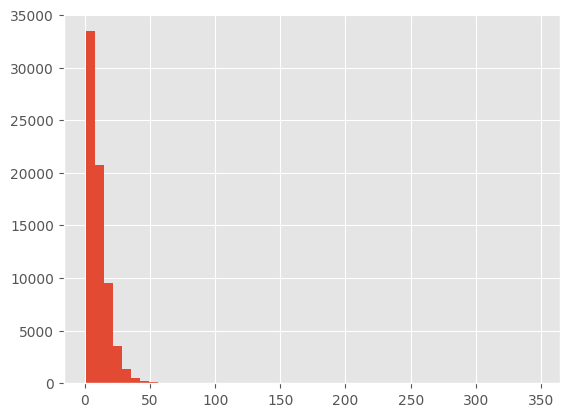

In [66]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

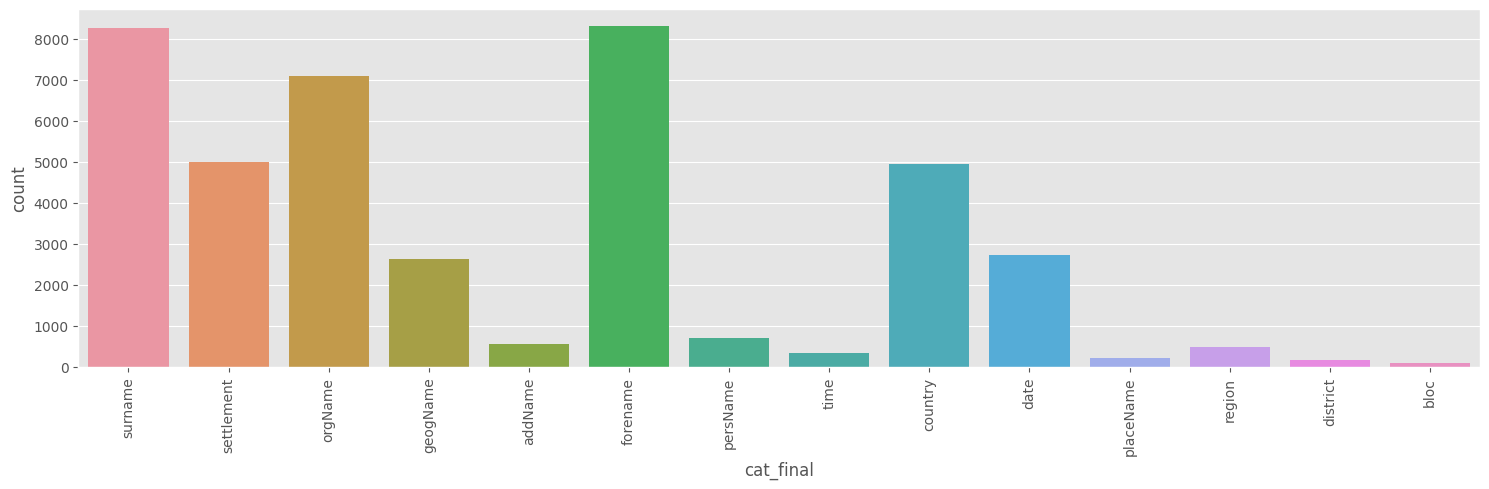

In [67]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('cat_final', data=data1.loc[data1['cat_final'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

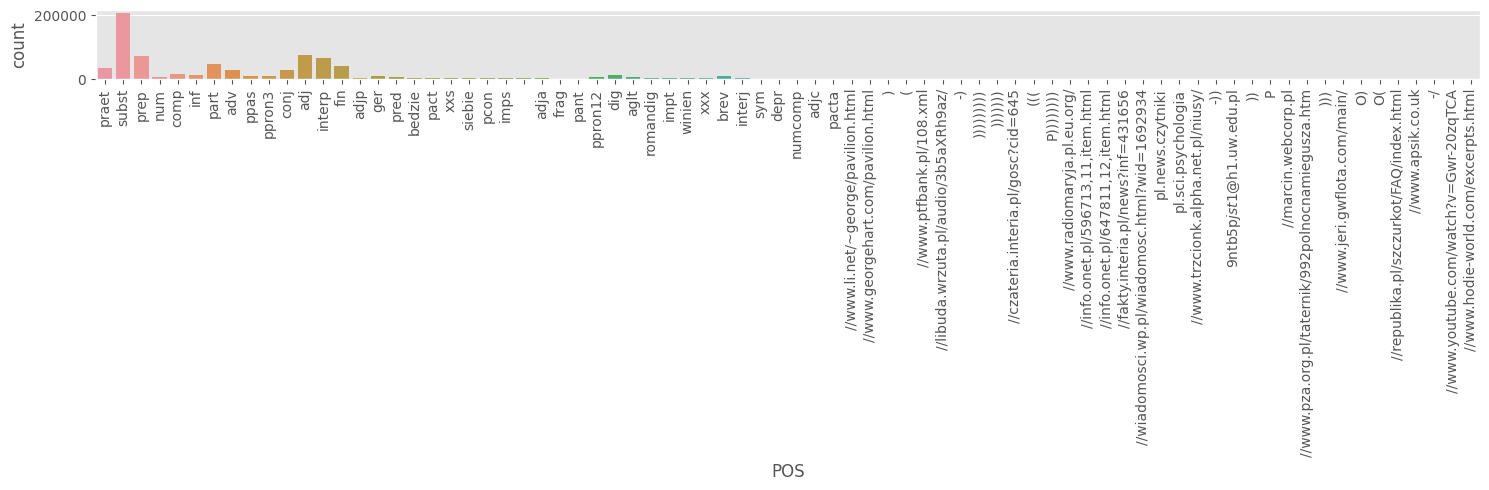

In [68]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data1, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [69]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [70]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data1["word"].values.tolist()]
tags = data1["cat_final"].values.tolist()

In [71]:
import sklearn_crfsuite

In [72]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import sklearn_crfsuite 
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
#import eli5

In [153]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)


In [154]:
report_tree_all = classification_report(y_pred=pred, y_true=tags,output_dict =True)
print(report_tree_all)

{'O': {'precision': 0.9443499848447671, 'recall': 0.9976350398353219, 'f1-score': 0.9702614827365041, 'support': 655825}, 'addName': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 568}, 'bloc': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 88}, 'country': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4934}, 'date': {'precision': 0.5362663495838288, 'recall': 0.3321060382916053, 'f1-score': 0.4101864483856298, 'support': 2716}, 'district': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 176}, 'forename': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8304}, 'geogName': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2629}, 'orgName': {'precision': 0.5848440899202321, 'recall': 0.22750352609308885, 'f1-score': 0.32757920389926887, 'support': 7090}, 'persName': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 699}, 'placeName': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support'

In [155]:
report_tree_all = pd.DataFrame(report_tree_all).transpose()
report_tree_all.to_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/INL/report_tree_all.csv')

In [73]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [74]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [75]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [76]:
def split_crf(words,tags):
    global tr_inputs, val_inputs, tr_tags, val_tags, test_inputs, test_tags
    tr_inputs, test_inputs, tr_tags, test_tags = train_test_split(words, tags,
                                                                random_state=2018, test_size=0.2)

    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(words, tags,
                                                                random_state=2018, test_size=0.375)

In [105]:
len(sentences)

69691

In [102]:
val_inputs

[[{'bias': 1.0,
   'word.lower()': '.',
   'word[-3:]': '.',
   'word[-2:]': '.',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'interp',
   'postag[:2]': 'in',
   'BOS': True,
   'EOS': True}],
 [{'bias': 1.0,
   'word.lower()': 'urodziła',
   'word[-3:]': 'iła',
   'word[-2:]': 'ła',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'praet',
   'postag[:2]': 'pr',
   'BOS': True,
   '+1:word.lower()': 'się',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'part',
   '+1:postag[:2]': 'pa'},
  {'bias': 1.0,
   'word.lower()': 'się',
   'word[-3:]': 'się',
   'word[-2:]': 'ię',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'part',
   'postag[:2]': 'pa',
   '-1:word.lower()': 'urodziła',
   '-1:word.istitle()': False,
   '-1:word.isupper()': False,
   '-1:postag': 'praet',
   '-1:postag[:2]': 'pr',
   '+1:word.l

In [77]:
split_crf(X,y)

In [161]:
from sklearn_crfsuite import CRF, metrics

In [72]:
%cat estimator.py

# -*- coding: utf-8 -*-
from __future__ import absolute_import

from six.moves import zip
from tqdm import tqdm
import pycrfsuite

from sklearn_crfsuite._fileresource import FileResource
from sklearn_crfsuite.trainer import LinePerIterationTrainer
from sklearn_crfsuite.compat import BaseEstimator


class CRF(BaseEstimator):
    """
    python-crfsuite wrapper with interface siimlar to scikit-learn.
    It allows to use a familiar fit/predict interface and scikit-learn
    model selection utilities (cross-validation, hyperparameter optimization).

    Unlike pycrfsuite.Trainer / pycrfsuite.Tagger this object is picklable;
    on-disk files are managed automatically.

    Parameters
    ----------
    algorithm : str, optional (default='lbfgs')
        Training algorithm. Allowed values:

        * ``'lbfgs'`` - Gradient descent using the L-BFGS method
        * ``'l2sgd'`` - Stochastic Gradient Descent with L2 regularization term
        * ``'ap'`` - Averaged Perceptron
        * ``'pa'

In [77]:
%cp /estimator.py /root/.local/lib/python3.8/site-packages/sklearn_crfsuite/

In [73]:
%cd /root/.local/lib/python3.8/site-packages/sklearn_crfsuite/

/root/.local/lib/python3.8/site-packages/sklearn_crfsuite


In [78]:
%ls

compat.py     _fileresource.py  metrics.py    scorers.py  utils.py
estimator.py  __init__.py       __pycache__/  trainer.py


In [211]:
pred = crf.predict( X=tr_inputs)

In [65]:
pred = cross_val_predict(estimator=crf, X=tr_inputs, y=tr_tags, cv=2)

In [66]:
from sklearn.preprocessing import MultiLabelBinarizer
pred_flat = MultiLabelBinarizer().fit_transform(pred)
tr_tags_flat = MultiLabelBinarizer().fit_transform(tr_tags)

In [68]:
#Lets evaluate the mode
report = classification_report(y_pred=pred_flat, y_true=tr_tags_flat
                              )
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43520
           1       0.67      0.13      0.22       311
           2       0.40      0.08      0.14        48
           3       0.90      0.76      0.82      2361
           4       0.94      0.76      0.84      1464
           5       0.45      0.05      0.09       103
           6       0.82      0.83      0.82      4324
           7       0.73      0.41      0.52      1320
           8       0.81      0.68      0.74      3397
           9       0.83      0.56      0.67       416
          10       0.94      0.25      0.39       120
          11       0.86      0.36      0.51       253
          12       0.80      0.66      0.73      2536
          13       0.83      0.83      0.83      4264
          14       0.88      0.57      0.69       214

   micro avg       0.95      0.91      0.93     64651
   macro avg       0.79      0.53      0.60     64651
weighted avg       0.94   

In [221]:
report = classification_report(y_pred=MultiLabelBinarizer().fit_transform(crf.predict( X=test_inputs)), y_true=MultiLabelBinarizer().fit_transform(test_tags) )
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13925
           1       0.80      0.19      0.30       107
           2       0.40      0.14      0.21        14
           3       0.91      0.82      0.86       774
           4       0.93      0.85      0.88       469
           5       0.71      0.15      0.24        34
           6       0.84      0.86      0.85      1380
           7       0.76      0.49      0.59       465
           8       0.82      0.70      0.76      1084
           9       0.90      0.71      0.80       126
          10       0.95      0.44      0.60        41
          11       0.95      0.40      0.57        97
          12       0.82      0.74      0.77       769
          13       0.85      0.84      0.85      1328
          14       0.86      0.59      0.70        63

   micro avg       0.95      0.92      0.94     20676
   macro avg       0.83      0.60      0.67     20676
weighted avg       0.95   

In [239]:
# flat_pred = [item for sublist in crf.predict( X=test_inputs) for item in sublist]
# flat_test = [item for sublist in test_tags for item in sublist]

In [192]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(crf.classes_)
labels = list(filter(lambda a: a != 'O', labels))
len(labels)

14

In [269]:
import sklearn_crfsuite


In [70]:
crf = sklearn_crfsuite.CRF(
...     algorithm='lbfgs',
...     c1=0.1,
...     c2=0.1,
...     max_iterations=100,
...     all_possible_transitions=True
... )
repr(crf)

"CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,\n    max_iterations=100)"

In [88]:
from collections import Counter


In [162]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(crf.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['geogName', 'orgName', 'country', 'forename', 'settlement', 'surname', 'persName', 'date', 'region', 'addName', 'time', 'placeName', 'bloc', 'district']


In [163]:
%%time
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(tr_inputs, tr_tags)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 5min 41s, sys: 21.6 s, total: 6min 3s
Wall time: 25min 40s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, c1=0.1, c2=0.1,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa1c65acc10>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa1c3d6eaf0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['geogName', 'orgName', 'country', 'forename', 'settlement', 'surname', 'persName', 'date', 'region', 'addName', 'time', 'placeName', 'bloc', 'district']),
                   verbose=1)

In [164]:
#Lets check the best estimated parameters and CV score
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.10890283108919009, 'c2': 0.0018533943031217685}
Best CV score: 0.7501213682702482
Model size: 2.26M


In [166]:
labels = list(rs.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['geogName', 'orgName', 'country', 'forename', 'settlement', 'surname', 'persName', 'date', 'region', 'addName', 'time', 'placeName', 'bloc', 'district']


In [167]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0]))

In [168]:
sorted_labels

['date',
 'addName',
 'region',
 'geogName',
 'persName',
 'settlement',
 'time',
 'district',
 'placeName',
 'bloc',
 'forename',
 'country',
 'orgName',
 'surname']

In [169]:
crf3 = rs.best_estimator_
y_pred =MultiLabelBinarizer().fit_transform(crf3.predict( X=tr_inputs))
tr_tags_vec = MultiLabelBinarizer().fit_transform(tr_tags)
report_train_cff = classification_report(
    tr_tags_vec, y_pred, output_dict=True)
print(classification_report(
    tr_tags_vec, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43520
           1       0.99      0.98      0.99       311
           2       0.95      0.85      0.90        48
           3       0.99      1.00      0.99      2361
           4       0.99      0.97      0.98      1464
           5       1.00      0.99      1.00       103
           6       0.98      1.00      0.99      4324
           7       0.99      0.97      0.98      1320
           8       0.98      0.97      0.98      3397
           9       0.99      0.98      0.98       416
          10       1.00      1.00      1.00       120
          11       1.00      0.99      1.00       253
          12       1.00      1.00      1.00      2536
          13       1.00      0.99      0.99      4264
          14       0.96      0.92      0.94       214

   micro avg       1.00      1.00      1.00     64651
   macro avg       0.99      0.97      0.98     64651
weighted avg       1.00   

In [170]:
report_train_cff = pd.DataFrame(report_train_cff).transpose()
report_train_cff.to_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/INL/report_train_cff.csv')

In [171]:
y_pred =MultiLabelBinarizer().fit_transform(crf3.predict( X=val_inputs))
val_tags_vec = MultiLabelBinarizer().fit_transform(val_tags)
report_valid_cff = classification_report(
    val_tags_vec, y_pred, output_dict=True)
print(classification_report(
    val_tags_vec, y_pred, output_dict=True))


{'0': {'precision': 0.9995022017997319, 'recall': 0.999961690227177, 'f1-score': 0.9997318932168984, 'support': 26103}, '1': {'precision': 0.6438356164383562, 'recall': 0.23618090452261306, 'f1-score': 0.34558823529411764, 'support': 199}, '2': {'precision': 0.42857142857142855, 'recall': 0.1935483870967742, 'f1-score': 0.26666666666666666, 'support': 31}, '3': {'precision': 0.9237097980553478, 'recall': 0.8594293667362561, 'f1-score': 0.8904109589041097, 'support': 1437}, '4': {'precision': 0.9247311827956989, 'recall': 0.8667413213885778, 'f1-score': 0.8947976878612717, 'support': 893}, '5': {'precision': 0.7272727272727273, 'recall': 0.13559322033898305, 'f1-score': 0.2285714285714286, 'support': 59}, '6': {'precision': 0.8705148205928237, 'recall': 0.8661233993015134, 'f1-score': 0.8683135576736044, 'support': 2577}, '7': {'precision': 0.7689594356261023, 'recall': 0.5093457943925234, 'f1-score': 0.6127898805340829, 'support': 856}, '8': {'precision': 0.8145658263305322, 'recall': 

In [172]:
report_valid_cff = pd.DataFrame(report_valid_cff).transpose()
report_valid_cff.to_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/INL/report_valid_cff.csv')

In [173]:
crf3.fit(val_inputs,val_tags)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.10890283108919009,
    c2=0.0018533943031217685, max_iterations=100)

In [174]:
y_pred =MultiLabelBinarizer().fit_transform(crf3.predict( X=val_inputs))
report_valid_cff_2 = classification_report(
    val_tags_vec, y_pred, output_dict=True)
#val_tags_vec = MultiLabelBinarizer().fit_transform(val_tags)
print(classification_report(
    val_tags_vec, y_pred, output_dict=True))


{'0': {'precision': 0.9998084878198253, 'recall': 1.0, 'f1-score': 0.9999042347398058, 'support': 26103}, '1': {'precision': 0.9948979591836735, 'recall': 0.9798994974874372, 'f1-score': 0.9873417721518988, 'support': 199}, '2': {'precision': 1.0, 'recall': 0.8387096774193549, 'f1-score': 0.9122807017543859, 'support': 31}, '3': {'precision': 0.9937673130193906, 'recall': 0.9986082115518441, 'f1-score': 0.9961818812912183, 'support': 1437}, '4': {'precision': 0.9909297052154195, 'recall': 0.9787234042553191, 'f1-score': 0.9847887323943662, 'support': 893}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 59}, '6': {'precision': 0.9880631497882172, 'recall': 0.9957314707023671, 'f1-score': 0.9918824893699266, 'support': 2577}, '7': {'precision': 0.9964664310954063, 'recall': 0.9883177570093458, 'f1-score': 0.9923753665689149, 'support': 856}, '8': {'precision': 0.9866004962779157, 'recall': 0.9817283950617284, 'f1-score': 0.9841584158415843, 'support': 2025}, '9': {'pr

In [175]:
report_valid_cff_2 = pd.DataFrame(report_valid_cff_2).transpose()
report_valid_cff_2.to_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/INL/report_valid_cff_2.csv')

In [176]:
#test final crf

In [177]:
#crf3 = rs.best_estimator_
y_pred =MultiLabelBinarizer().fit_transform(crf3.predict( X=test_inputs))
test_tags_vec = MultiLabelBinarizer().fit_transform(test_tags)
report_test_cff = classification_report(
    test_tags_vec, y_pred, output_dict=True)
print(classification_report(
    test_tags_vec, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13925
           1       0.99      0.97      0.98       107
           2       1.00      0.79      0.88        14
           3       0.99      1.00      1.00       774
           4       1.00      0.99      0.99       469
           5       1.00      1.00      1.00        34
           6       0.98      1.00      0.99      1380
           7       1.00      0.98      0.99       465
           8       0.99      0.98      0.98      1084
           9       0.98      0.98      0.98       126
          10       1.00      1.00      1.00        41
          11       0.99      0.99      0.99        97
          12       1.00      1.00      1.00       769
          13       0.99      0.99      0.99      1328
          14       0.95      0.92      0.94        63

   micro avg       1.00      1.00      1.00     20676
   macro avg       0.99      0.97      0.98     20676
weighted avg       1.00   

In [178]:
report_test_cff = pd.DataFrame(report_test_cff).transpose()
report_test_cff.to_csv('/home/jan.solarz/Pobrane/Jan Solarz- Projects/INL/report_test_cff.csv')

# Summary of preprocessing and CT/CRF explanation

## The comparison will be shown in Comparison_NER.ipynb notebook

Manipulation on the input data and features engineering:
- All mark with the interp tag have been transformed into "."
- "sentence_number" variable was giving information about the number of sentence to which the word belongs
- function word2feature generates all the needed features which are used in the trained models


Observations about the dataset of words:
- the dataset after preprocessing contains almost 700k words
- "O" tag has 94% of all tags which means that there are 41561 names entities.
- tags as Surname, Forename and Settlement have the highest frequency
- Length of sentences is almost always in the range (0,50), most sentences contains the smallest numbers of words
-  42245 words start with upper letter, and are not at the beginning of the sentence. More than 12k in that group has tag "O".

We built:
- classification decision tree on the all data with cross validation with cv=5 and estimator_number=20
- conditional random field with separate train, valid and test data:
   - normal approach with CV with 2 folds and default parameters.
   - randomized CV search CRF wherein we will use a modified F1 scorer model considering only the relevant labels define fixed parameters and parameters to search. Fitting 3 folds for each of 50 candidates, totalling 150 fits. Final best parameters: 'c1': 0.10890283108919009, 'c2': 0.0018533943031217685, max_iter = 100, n_iter:50.
      
      